In [1]:
#1: Imports & SparkSession
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col, to_date, month, when, count, avg, sum as _sum, desc, trim, regexp_replace
from pyspark.sql.types import *
import pandas as pd
import os, shutil
from pyspark.sql import DataFrame
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("TelanganaTourism_Presentation") \
    .config("spark.driver.memory", "4g") \
    .master("local[*]") \
    .getOrCreate()

print('Spark session started:', spark)

Spark session started: <pyspark.sql.session.SparkSession object at 0x0000025EFF9A9610>


In [3]:
#2: Load the dataset
import os
path = 'Tourism_data.csv'

sdf = spark.read.csv("Tourism_Data.csv", header=True, inferSchema=True)
sdf.printSchema()

print('Rows:', sdf.count(), 'Columns:', len(sdf.columns))

root
 |-- District: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Visitors: double (nullable = true)
 |-- Year: string (nullable = true)
 |-- Season: string (nullable = true)

Rows: 10000 Columns: 5


In [5]:
#3: View first 10 rows
print("=== First 10 rows of dataset ===")
sdf.show(15, truncate=False)

=== First 10 rows of dataset ===
+---------------------+---------+--------+----+-------+
|District             |Month    |Visitors|Year|Season |
+---------------------+---------+--------+----+-------+
|Adilabad             |January  |621850.0|2020|Monsoon|
|Adilabad             |February |29421.0 |2020|Monsoon|
|Adilabad             |March    |9430.0  |2020|Monsoon|
|Adilabad             |June     |1909.0  |2020|Winter |
|Adilabad             |July     |549.0   |2020|Winter |
|Adilabad             |August   |654.0   |2020|Autumn |
|Adilabad             |September|3978.0  |2020|Summer |
|Adilabad             |October  |15128.0 |2020|Autumn |
|Adilabad             |November |27525.0 |2020|Autumn |
|Adilabad             |December |61403.0 |2020|Monsoon|
|Bhadradri Kothagudem |January  |269310.0|2020|Summer |
|Bhadradri Kothagudem |February |238140.0|2020|Winter |
|Bhadradri Kothagudem |March    |79871.0 |2020|Autumn |
|Bhadradri Kothagudem |June     |15399.0 |2020|Autumn |
|Bhadradri Koth

In [7]:
#4: Data cleaning & type conversions 
# Trim column names and values
for c in sdf.columns:
    sdf = sdf.withColumnRenamed(c, c.strip())

# Trim string columns
for c in ['District', 'Month', 'Season']:
    if c in sdf.columns:
        sdf = sdf.withColumn(c, trim(col(c)))

# Handle Visitors and Year safely
if 'Visitors' in sdf.columns:
    # Remove commas and non-numeric characters before casting
    sdf = sdf.withColumn('Visitors', regexp_replace(col('Visitors'), '[^0-9\\.]', ''))
    sdf = sdf.withColumn('Visitors', col('Visitors').cast('double'))

if 'Year' in sdf.columns:
    # Convert only if the value is 4 digits (like 2020, 2021, etc.)
    sdf = sdf.withColumn(
        'Year',
        when(col('Year').rlike('^[0-9]{4}$'), col('Year').cast('int')).otherwise(None)
    )

# Drop rows where Year or Visitors is NULL after cleanup
sdf = sdf.filter(col('Year').isNotNull() & col('Visitors').isNotNull())

print("Cleaned data successfully.")
print(f"Rows after cleaning: {sdf.count()}")
print("=== Schema of dataset ===")
sdf.printSchema()
sdf.show(10)

Cleaned data successfully.
Rows after cleaning: 9957
=== Schema of dataset ===
root
 |-- District: string (nullable = true)
 |-- Month: string (nullable = true)
 |-- Visitors: double (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Season: string (nullable = true)

+--------+---------+--------+----+-------+
|District|    Month|Visitors|Year| Season|
+--------+---------+--------+----+-------+
|Adilabad|  January|621850.0|2020|Monsoon|
|Adilabad| February| 29421.0|2020|Monsoon|
|Adilabad|    March|  9430.0|2020|Monsoon|
|Adilabad|     June|  1909.0|2020| Winter|
|Adilabad|     July|   549.0|2020| Winter|
|Adilabad|   August|   654.0|2020| Autumn|
|Adilabad|September|  3978.0|2020| Summer|
|Adilabad|  October| 15128.0|2020| Autumn|
|Adilabad| November| 27525.0|2020| Autumn|
|Adilabad| December| 61403.0|2020|Monsoon|
+--------+---------+--------+----+-------+
only showing top 10 rows


In [9]:
# Count total number of rows and columns
print("=== Total no.of rows ===")
print(sdf.count())
print("=== List of columns ===")
print(sdf.columns)

=== Total no.of rows ===
9957
=== List of columns ===
['District', 'Month', 'Visitors', 'Year', 'Season']


In [11]:
# Select specific columns
print("=== Print District and Visitors columns ===")
sdf.select("District", "Visitors").show(15)

=== Print District and Visitors columns ===
+--------------------+--------+
|            District|Visitors|
+--------------------+--------+
|            Adilabad|621850.0|
|            Adilabad| 29421.0|
|            Adilabad|  9430.0|
|            Adilabad|  1909.0|
|            Adilabad|   549.0|
|            Adilabad|   654.0|
|            Adilabad|  3978.0|
|            Adilabad| 15128.0|
|            Adilabad| 27525.0|
|            Adilabad| 61403.0|
|Bhadradri Kothagudem|269310.0|
|Bhadradri Kothagudem|238140.0|
|Bhadradri Kothagudem| 79871.0|
|Bhadradri Kothagudem| 15399.0|
|Bhadradri Kothagudem| 15130.0|
+--------------------+--------+
only showing top 15 rows


In [13]:
# Districts with Visitors > 50000
print("=== Print Districts with greater than 50000 Visitors ===")
sdf.filter(sdf.Visitors > 50000).show(15)

=== Print Districts with greater than 50000 Visitors ===
+--------------------+--------+---------+----+-------+
|            District|   Month| Visitors|Year| Season|
+--------------------+--------+---------+----+-------+
|            Adilabad| January| 621850.0|2020|Monsoon|
|            Adilabad|December|  61403.0|2020|Monsoon|
|Bhadradri Kothagudem| January| 269310.0|2020| Summer|
|Bhadradri Kothagudem|February| 238140.0|2020| Winter|
|Bhadradri Kothagudem|   March|  79871.0|2020| Autumn|
|Bhadradri Kothagudem|November|  76900.0|2020| Autumn|
|Bhadradri Kothagudem|December|  80842.0|2020| Winter|
|           Hyderabad| January|1157153.0|2020|Monsoon|
|           Hyderabad|February| 868641.0|2020| Autumn|
|           Hyderabad|   March| 321650.0|2020| Summer|
|           Hyderabad| October| 167510.0|2020| Winter|
|           Hyderabad|November| 272276.0|2020| Winter|
|           Hyderabad|December| 442895.0|2020|Monsoon|
|             Jagtial| January| 340174.0|2020|Monsoon|
|       

In [15]:
# Districts with Visitors > 50000 in the Season "Monsoon" 
print("\n=== Print Districts with Visitors in Monsoon Season ===")
sdf.filter((sdf.Season == "Monsoon") & (sdf.Visitors >= 50000 )).show(15)


=== Print Districts with Visitors in Monsoon Season ===
+----------------+---------+----------------+----+-------+
|        District|    Month|        Visitors|Year| Season|
+----------------+---------+----------------+----+-------+
|        Adilabad|  January|        621850.0|2020|Monsoon|
|        Adilabad| December|         61403.0|2020|Monsoon|
|       Hyderabad|  January|       1157153.0|2020|Monsoon|
|       Hyderabad| December|        442895.0|2020|Monsoon|
|         Jagtial|  January|        340174.0|2020|Monsoon|
|         Jagtial| December|        155757.0|2020|Monsoon|
|Jogulamba Gadwal|     July|         88182.0|2020|Monsoon|
|Jogulamba Gadwal|  October|        116753.0|2020|Monsoon|
|Jogulamba Gadwal| December|        184380.0|2020|Monsoon|
|         Khammam| February|        114417.0|2020|Monsoon|
|           Medak|    March|        288800.0|2020|Monsoon|
|         Medchal|    April|84336.4890920171|2020|Monsoon|
|          Mulugu|  January|       3653000.0|2020|Monsoon|

In [17]:
# Calculate Average, minimum and maximum Visitors
from pyspark.sql.functions import avg, min, max

print("=== Print average, minimum, maximum Visitors ===")
sdf.agg(
    avg("Visitors").alias("avg_Visitors"),
    min("Visitors").alias("min_Visitors"),
    max("Visitors").alias("max_Visitors")
).show()

=== Print average, minimum, maximum Visitors ===
+----------------+------------+------------+
|    avg_Visitors|min_Visitors|max_Visitors|
+----------------+------------+------------+
|84754.4256252254|         0.0|   9761776.0|
+----------------+------------+------------+



In [19]:
spark = SparkSession.builder.appName("TourismData").getOrCreate()

df = spark.read.csv("tourism_data.csv", header=True, inferSchema=True)


In [21]:
#Calculate average Visitors by Districts
print("=== Print average Visitors by Districts ===")
df.groupBy("District").agg(avg("Visitors").alias("avg_Visitors")).show()

=== Print average Visitors by Districts ===
+--------------------+------------------+
|            District|      avg_Visitors|
+--------------------+------------------+
|         Wanaparthy |14359.019814846402|
| Yadadri Bhongir ??3|            2021.0|
| Yadadri Bhongir ??1| 2021.993760099357|
|         Sangareddy | 140419.2831635696|
|         Hanumakonda|22998.938986810812|
| Nalgonda & Suryapet| 15890.46117443586|
|             Jagtial|104126.25939065673|
|        Nagarkurnool|52174.563853270825|
|    Warangal (Rural)| 6956.248749799342|
|     RajanuaSircilla|426730.58662333165|
|        Mahabubabad | 4998.124291867931|
| Yadadri Bhongir ??6|            2021.0|
|Bhadradri Kothagudem| 37771.35094290283|
| Yadadri Bhongir ??2|2046.8536115383536|
|      YadadriBhongir| 637928.0284076603|
|        Mababubnagar| 50428.91355817711|
|              Mulugu|289074.20288613264|
|         Ranga Reddy| 84377.82756207163|
|            Medchal | 84167.22505867956|
| Yadadri Bhongir ??4|          

In [23]:
#5: Total visitors overall and by year (show table)
if 'Visitors' in sdf.columns:
    total_visitors = sdf.agg(_sum('Visitors').alias('Total_Visitors')).collect()[0]['Total_Visitors']
    print('Total visitors (sum):', int(total_visitors))
    visitors_by_year = sdf.groupBy('Year').agg(_sum('Visitors').alias('Visitors')).orderBy('Year')
    visitors_by_year.show()
else:
    print('Visitors column not found; cannot compute totals.')

Total visitors (sum): 843899815
+----+--------------------+
|Year|            Visitors|
+----+--------------------+
|2018|1.1650302280449158E8|
|2019|1.0172433901397155E8|
|2020| 3.391727679132523E8|
|2021| 7.617949346799825E7|
|2022|1.4043041361078408E8|
|2023| 6.988977913987644E7|
+----+--------------------+



,District,TotalVisitors
0,Mulugu,8.730041e+07
1,"Hyderabad, Ranga Reddy, Medchal & Vikarabad",7.092776e+07
2,Yadadri Bhongir,5.667148e+07
3,Rajanna Sircilla,5.573950e+07
4,Hyderabad,5.199397e+07
5,Nirmal,4.557907e+07
6,"Hyderabad, Ranga Reddy, Medchal -Malkajigiri, ...",4.355650e+07
7,Jagtial,3.704872e+07
8,Mahbubnagar,3.299148e+07
9,Medak,3.267829e+07


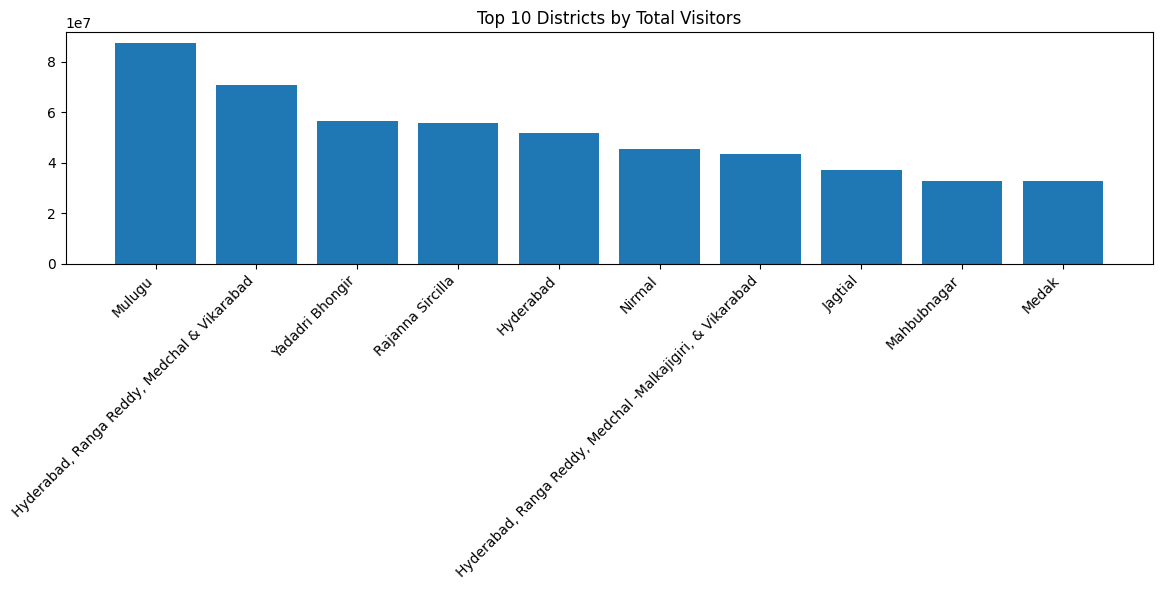

In [25]:
#6: Top 10 districts by visitors (bar chart)
if 'District' in sdf.columns and 'Visitors' in sdf.columns:
    district_totals = sdf.groupBy('District').agg(_sum('Visitors').alias('TotalVisitors'))
    top10 = district_totals.orderBy(desc('TotalVisitors')).limit(10)
    top10_pd = top10.toPandas()
    display(top10_pd)
    # plot and save
    plt.figure(figsize=(12,6))
    plt.bar(top10_pd['District'], top10_pd['TotalVisitors'])
    plt.xticks(rotation=45, ha='right')
    plt.title('Top 10 Districts by Total Visitors')
    plt.tight_layout()
    plt.savefig('top10_districts_pyspark.png')
    plt.show()
else:
    print('District or Visitors column missing.')


,Season,Visitors
0,Summer,2.302606e+08
1,Winter,2.082089e+08
2,Autumn,2.041030e+08
3,Monsoon,2.013274e+08


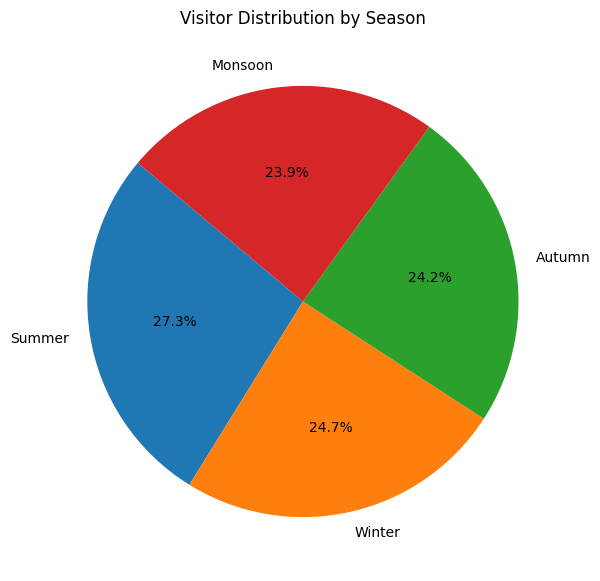

In [27]:
#7: Visitors by season (pie chart)
if 'Season' in sdf.columns and 'Visitors' in sdf.columns:
    season_agg = sdf.groupBy('Season').agg(_sum('Visitors').alias('Visitors')).orderBy(desc('Visitors'))
    season_pd = season_agg.toPandas()
    display(season_pd)
    plt.figure(figsize=(7,7))
    plt.pie(season_pd['Visitors'], labels=season_pd['Season'], autopct='%1.1f%%', startangle=140)
    plt.title('Visitor Distribution by Season')
    plt.savefig('season_distribution_pyspark.png')
    plt.show()
else:
    print('Season or Visitors column missing.')

Year,2018,2019,2020,2021,2022,2023
Month,,,,,,
January,2.304613e+07,1.306140e+07,5.548035e+07,7.698450e+06,1.455481e+07,5.581846e+06
February,1.961839e+07,8.560414e+06,8.702572e+07,9.589323e+06,2.501615e+07,1.038709e+07
March,9.538121e+06,8.591641e+06,3.007686e+07,9.210049e+06,1.450256e+07,6.170623e+06
April,6.612990e+06,7.712648e+06,1.338463e+07,3.960095e+06,1.194489e+07,4.801422e+06
May,1.091415e+07,6.559008e+06,1.308884e+07,6.080452e+05,1.054580e+07,5.290756e+06


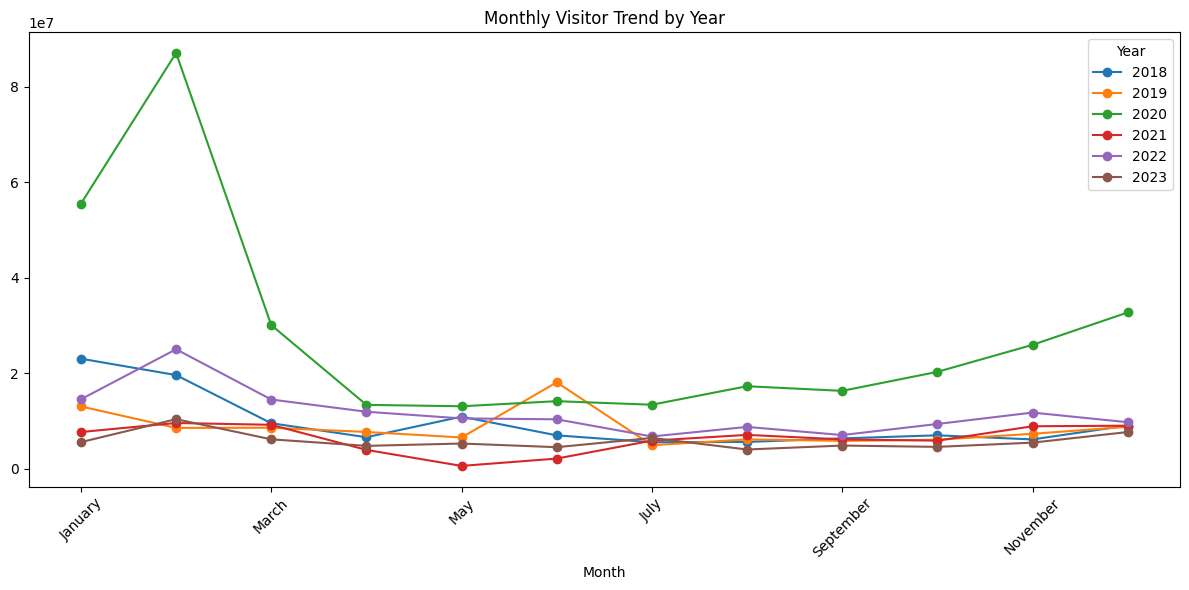

In [29]:
#8: Monthly trend by year (line chart)
if 'Month' in sdf.columns and 'Year' in sdf.columns and 'Visitors' in sdf.columns:
    # Ensure month ordering (January..December)
    month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
    sdf = sdf.withColumn('Month', col('Month'))
    monthly = sdf.groupBy('Year','Month').agg(_sum('Visitors').alias('Visitors'))
    monthly_pd = monthly.toPandas()
    # pivot for plotting
    monthly_pd['Month'] = pd.Categorical(monthly_pd['Month'], categories=month_order, ordered=True)
    pivot = monthly_pd.pivot(index='Month', columns='Year', values='Visitors').fillna(0)
    display(pivot.head())
    pivot.plot(figsize=(12,6), marker='o')
    plt.title('Monthly Visitor Trend by Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('monthly_trend_pyspark.png')
    plt.show()
else:
    print('Month/Year/Visitors columns required for monthly trend.')


Month,January,February,March,April,May,June,July,August,September,October,November,December
District,,,,,,,,,,,,
Mulugu,1.894266e+07,6.115279e+07,1.064364e+06,6.434711e+05,6.137175e+05,5.082515e+05,6.107990e+05,8.611499e+05,6.028563e+05,7.160090e+05,7.539668e+05,8.303789e+05
"Hyderabad, Ranga Reddy, Medchal & Vikarabad",5.358602e+06,5.489300e+06,4.231201e+06,4.983458e+06,4.609101e+06,5.149972e+06,4.398425e+06,5.620664e+06,5.726929e+06,7.421823e+06,8.905483e+06,9.032806e+06
Yadadri Bhongir,6.418419e+06,6.204362e+06,5.985239e+06,2.128972e+06,3.429009e+06,4.574085e+06,4.460765e+06,3.701598e+06,3.500963e+06,5.185572e+06,4.737823e+06,6.344678e+06
Rajanna Sircilla,1.761115e+07,5.899246e+06,6.919291e+06,3.130976e+06,4.011322e+06,2.754854e+06,1.729149e+06,1.349720e+06,1.685914e+06,1.879320e+06,3.669730e+06,5.098831e+06
Hyderabad,9.482524e+06,5.020367e+06,4.777409e+06,2.632308e+06,3.646787e+06,2.858062e+06,2.564903e+06,2.712850e+06,2.533617e+06,3.950879e+06,4.109659e+06,7.704610e+06
Nirmal,4.343136e+06,4.358788e+06,4.401722e+06,3.142155e+06,2.622911e+06,3.867072e+06,3.478662e+06,3.525405e+06,3.987254e+06,3.365965e+06,4.313736e+06,4.172259e+06
"Hyderabad, Ranga Reddy, Medchal -Malkajigiri, & Vikarabad",3.624622e+06,3.899501e+06,3.477321e+06,2.717892e+06,3.619396e+06,2.849230e+06,3.708046e+06,2.719338e+06,2.613014e+06,3.854064e+06,3.350392e+06,7.123687e+06
Jagtial,4.596920e+06,3.067479e+06,5.685713e+06,3.091987e+06,3.484416e+06,2.460978e+06,1.909220e+06,2.193391e+06,1.730724e+06,1.898602e+06,3.390250e+06,3.539039e+06
Mahbubnagar,1.948928e+06,6.674093e+06,3.068659e+06,2.528103e+06,1.242712e+06,1.528003e+06,2.025969e+06,2.340848e+06,2.369698e+06,2.418382e+06,4.324890e+06,2.521194e+06


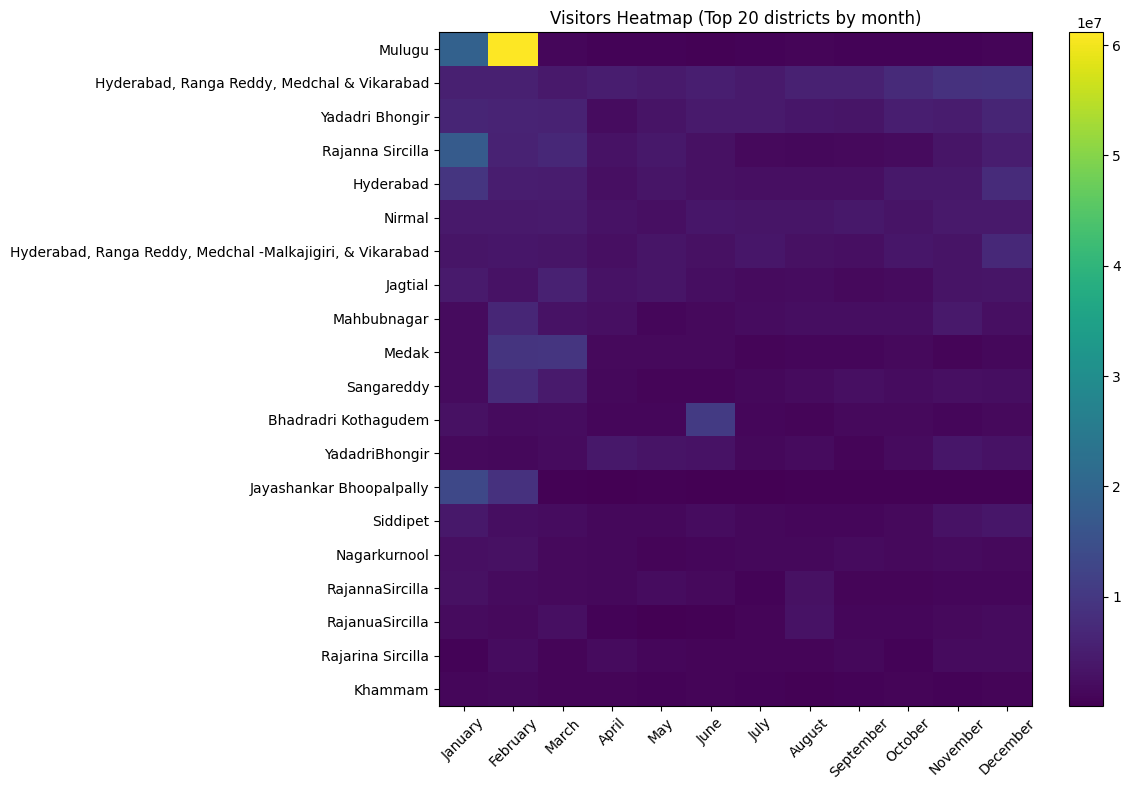

In [31]:
#9: District vs Month heatmap (top 20 districts)
if 'District' in sdf.columns and 'Month' in sdf.columns and 'Visitors' in sdf.columns:
    from pyspark.sql import Window
    district_tot = sdf.groupBy('District').agg(_sum('Visitors').alias('TotalVisitors'))
    top20 = district_tot.orderBy(desc('TotalVisitors')).limit(20).toPandas()['District'].tolist()
    heat_df = sdf.filter(col('District').isin(top20)).groupBy('District','Month').agg(_sum('Visitors').alias('Visitors'))
    heat_pd = heat_df.toPandas()
    heat_pivot = heat_pd.pivot(index='District', columns='Month', values='Visitors').fillna(0)
    # reorder rows and columns
    heat_pivot = heat_pivot.reindex(index=top20)
    heat_pivot = heat_pivot.reindex(columns=month_order, fill_value=0)
    display(heat_pivot)
    plt.figure(figsize=(12,8))
    plt.imshow(heat_pivot.values, aspect='auto')
    plt.yticks(range(len(heat_pivot.index)), heat_pivot.index)
    plt.xticks(range(len(heat_pivot.columns)), heat_pivot.columns, rotation=45)
    plt.title('Visitors Heatmap (Top 20 districts by month)')
    plt.colorbar()
    plt.tight_layout()
    plt.savefig('district_month_heat_top20_pyspark.png')
    plt.show()
else:
    print('Columns needed: District, Month, Visitors')

